In this notebook, we'll examine computing ciliary beat frequency (CBF) from a couple example videos using the core techniques from the [2015 Quinn *et al* paper in *Science Translational Medicine*](http://dx.doi.org/10.1126/scitranslmed.aaa1233).

CBF is a quantity that clinicians and researchers have used for some time as an objective measure of ciliary motion. It is precisely what it sounds like: the frequency at which cilia beat. This can be easily done in a GUI-viewer like ImageJ (now Fiji) by clicking on a single pixel of the video and asking for the frequency, but in Python this requires some additional work.

With any spectral analysis of a time series, we'll be presented with a range of frequencies present at any given location. In our paper, we limited the scope of these frequencies to only the *dominant* frequency that was present *at each pixel*. In essence, we compute the frequency spectra at each pixel of a video of cilia, then strip out all the frequencies at each pixel except for the one with the greatest power.

There are three main ways in which we computed CBF. Each of these is implemented in `stm.py`.

#### 0: Preliminaries

Here are some basic imports we'll need for the rest of the notebook.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

import stm  # Our package.

In [2]:
# Our two example videos.
v_norm = np.load("../data/normal.npy")
v_dysk = np.load("../data/dyskinetic.npy")

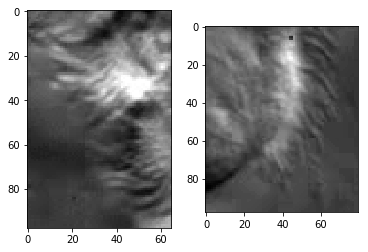

In [3]:
# We'll plot the first frame of these two videos to give a sense of them.

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(v_norm[0], cmap = "gray")
plt.subplot(1, 2, 2)
plt.imshow(v_dysk[0], cmap = "gray")

#### 1: "Raw" FFT-based CBF

The title is something of a misnomer: the computed CBF is not "raw" in any sense, and all our CBF computations use the FFT in some regard. This technique, however, is the only that *explicitly* uses the FFT. It's also the most basic technique, as it doesn't involve any shifting or windowing of the original signal. As a result, it's very fast, but can produce a lot of noise.

Here's what it looks like.

In [4]:
h1_norm = stm.cbf(v_norm, method = "fft")
h1_dysk = stm.cbf(v_dysk, method = "fft")

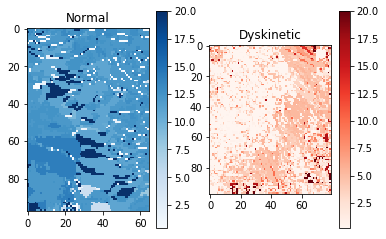

In [5]:
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Normal")
plt.imshow(h1_norm, cmap = "Blues")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Dyskinetic")
plt.imshow(h1_dysk, cmap = "Reds")
plt.colorbar()

This is a pretty noisy estimation but still gives a good idea of where certain frequencies are present. Note that in some locations around the cilia in both cases, there is saturation of the signal: large pixel areas that are indicating maximal CBF. These are likely noise as well.

A common post-processing step we would perform is a median filter to dampen spurious signals. The only drawback of this approach is that it assumes a very small amount of noise relative to signal; the reality is likely that there is more noise than this approach implicitly assumes. Nonetheless it is still worthwhile:

In [6]:
h1_norm_filt = signal.medfilt2d(h1_norm, 5)  # Kernel size of 5x5.
h1_dysk_filt = signal.medfilt2d(h1_dysk, 5)

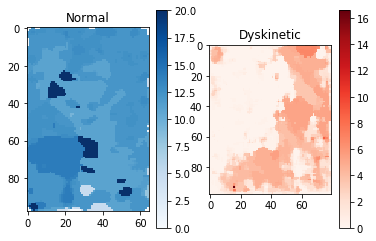

In [7]:
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Normal")
plt.imshow(h1_norm_filt, cmap = "Blues")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Dyskinetic")
plt.imshow(h1_dysk_filt, cmap = "Reds")
plt.colorbar()

It was also useful to look at histograms of the frequencies that are present, discarding the spatial representation in favor of a distribution of frequencies.

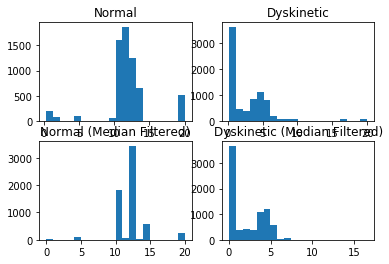

In [8]:
plt.figure()
plt.subplot(2, 2, 1)
plt.title("Normal")
_ = plt.hist(h1_norm.flatten(), bins = 20)

plt.subplot(2, 2, 2)
plt.title("Dyskinetic")
_ = plt.hist(h1_dysk.flatten(), bins = 20)

plt.subplot(2, 2, 3)
plt.title("Normal (Median Filtered)")
_ = plt.hist(h1_norm_filt.flatten(), bins = 20)

plt.subplot(2, 2, 4)
plt.title("Dyskinetic (Median Filtered)")
_ = plt.hist(h1_dysk_filt.flatten(), bins = 20)

#### 2: Periodogram

A periodogram is an estimate of the power spectral density (PSD, hence the name) of the signal, and is a step up from pixel-based FFT...but only 1 step. It performs a lot of the same steps as in the first method under-the-hood, and thus the code in the attached module is considerably shorter.

In theory, this method is a bit more robust to noise.

In [9]:
h2_norm = stm.cbf(v_norm, method = "psd")
h2_dysk = stm.cbf(v_dysk, method = "psd")

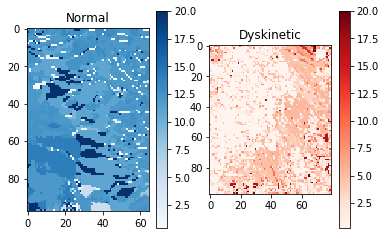

In [10]:
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Normal")
plt.imshow(h2_norm, cmap = "Blues")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Dyskinetic")
plt.imshow(h2_dysk, cmap = "Reds")
plt.colorbar()

There are some minute differences from the first method, but not much.

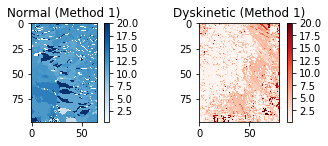

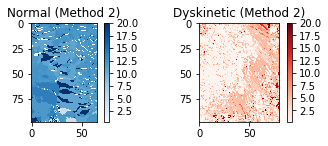

In [11]:
plt.figure()
plt.subplot(2, 2, 1)
plt.title("Normal (Method 1)")
plt.imshow(h1_norm, cmap = "Blues")
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title("Dyskinetic (Method 1)")
plt.imshow(h1_dysk, cmap = "Reds")
plt.colorbar()

plt.figure()
plt.subplot(2, 2, 3)
plt.title("Normal (Method 2)")
plt.imshow(h2_norm, cmap = "Blues")
plt.colorbar()

plt.subplot(2, 2, 4)
plt.title("Dyskinetic (Method 2)")
plt.imshow(h2_dysk, cmap = "Reds")
plt.colorbar()

We can do our post-processing.

In [12]:
h2_norm_filt = signal.medfilt2d(h2_norm, 5)  # Kernel size of 5x5.
h2_dysk_filt = signal.medfilt2d(h2_dysk, 5)

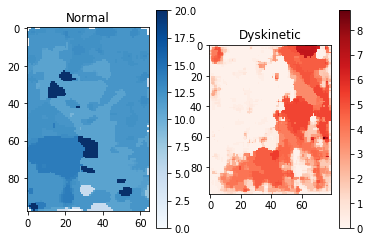

In [13]:
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Normal")
plt.imshow(h2_norm_filt, cmap = "Blues")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Dyskinetic")
plt.imshow(h2_dysk_filt, cmap = "Reds")
plt.colorbar()

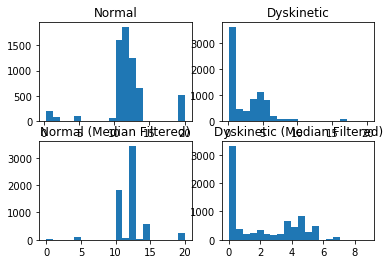

In [14]:
plt.figure()
plt.subplot(2, 2, 1)
plt.title("Normal")
_ = plt.hist(h2_norm.flatten(), bins = 20)

plt.subplot(2, 2, 2)
plt.title("Dyskinetic")
_ = plt.hist(h2_dysk.flatten(), bins = 20)

plt.subplot(2, 2, 3)
plt.title("Normal (Median Filtered)")
_ = plt.hist(h2_norm_filt.flatten(), bins = 20)

plt.subplot(2, 2, 4)
plt.title("Dyskinetic (Median Filtered)")
_ = plt.hist(h2_dysk_filt.flatten(), bins = 20)

#### 3: Welch Periodogram

Think of Welch's algorithm as a post-processing of the periodogram: it performs window-based smoothing on the resulting frequency spectra, dampening noise at the expense of frequency resolution. Given the propensity of frequency-based noise to appear in the resulting spectra, this trade-off is often preferred.

In [15]:
h3_norm = stm.cbf(v_norm, method = "welch")
h3_dysk = stm.cbf(v_dysk, method = "welch")

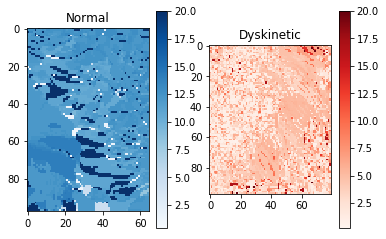

In [16]:
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Normal")
plt.imshow(h3_norm, cmap = "Blues")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Dyskinetic")
plt.imshow(h3_dysk, cmap = "Reds")
plt.colorbar()

In [17]:
h3_norm_filt = signal.medfilt2d(h3_norm, 5)  # Kernel size of 5x5.
h3_dysk_filt = signal.medfilt2d(h3_dysk, 5)

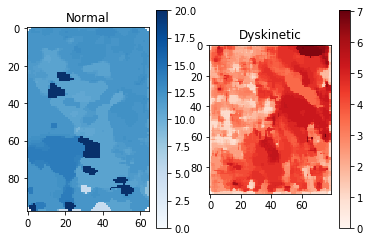

In [18]:
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Normal")
plt.imshow(h3_norm_filt, cmap = "Blues")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Dyskinetic")
plt.imshow(h3_dysk_filt, cmap = "Reds")
plt.colorbar()

Strangely, the dyskinetic video seems to see a considerable increase in frequencies across the board once the median filter is applied. We'll look at the histogram for a better view.

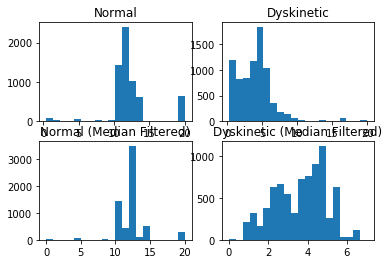

In [19]:
plt.figure()
plt.subplot(2, 2, 1)
plt.title("Normal")
_ = plt.hist(h3_norm.flatten(), bins = 20)

plt.subplot(2, 2, 2)
plt.title("Dyskinetic")
_ = plt.hist(h3_dysk.flatten(), bins = 20)

plt.subplot(2, 2, 3)
plt.title("Normal (Median Filtered)")
_ = plt.hist(h3_norm_filt.flatten(), bins = 20)

plt.subplot(2, 2, 4)
plt.title("Dyskinetic (Median Filtered)")
_ = plt.hist(h3_dysk_filt.flatten(), bins = 20)

This is interesting--there must be something about the spatial arrangement of dominant frequencies in the dyskinetic video (from Welch's method only) that results in a huge shift in the frequencies that are present.

Or it just might be a bug somewhere.